# Deep Learning with AMD devices

## Plan for today

1. Learn about ROCm
    - Understand what is ROCm.  
    - Get familiar with AMD GPUs that have ROCm support.  
    - PyTorch interface for AMD GPUs.  
2. See it's usages in pratice
    - Classification  

# ROCm

**Radeon Open Compute Ecosystem (ROCm)** is the general-purpose computing platform. Unlike CUDA, the ROCm software stack can take advantage of several domains, such as general-purpose GPGPU, high-performance computing (HPC), and heterogeneous computing.

Since **PyTorch 1.8** release, users of PyTorch can use the ROCm™ open software platform to speed up compute-intensive applications by harnessing the power of GPUs. This provides a option for data scientists, researchers, students, and others in the community to get started with accelerated PyTorch using AMD GPUs.

# AMD GPUs with ROCm support

ROCm officially supports AMD GPUs that use following chips:

- **Vega**

  - Vega 10 chips, such as [Radeon Instinct MI25](https://www.amd.com/en/products/professional-graphics/instinct-mi25)

  - Vega 20 chips, such as on the [Radeon Instinct MI50](https://www.amd.com/en/products/professional-graphics/instinct-mi50), [Radeon Instinct MI60](https://www.amd.com/system/files/documents/radeon-instinct-mi60-datasheet.pdf) or [AMD Radeon VII](https://www.amd.com/en/support/graphics/amd-radeon-2nd-generation-vega/amd-radeon-2nd-generation-vega/amd-radeon-vii), [Radeon Pro VII](https://www.amd.com/en/support/professional-graphics/radeon-pro/radeon-pro-vii/radeon-pro-vii)
   

- **CDNA GPUs**

   - MI100 chips such as on the [AMD Instinct™ MI100](https://www.amd.com/en/graphics/instinct-server-accelerators)
   
   - MI200 chips such as on the [AMD Instinct™ MI200](https://www.amd.com/en/graphics/instinct-server-accelerators)
   
- **RDNA GPUs**

   - [RDNA2](https://www.amd.com/en/technologies/rdna)
   
   - [RDNA3](https://www.amd.com/en/technologies/rdna)
   

# ROCm and PyTorch

HIP is ROCm’s C++ dialect designed to ease conversion of CUDA applications to portable C++ code.

PyTorch for HIP intentionally reuses the existing torch.cuda interfaces. This helps to accelerate the porting of existing PyTorch code and models because very few code changes are necessary, if any

In [1]:
# !pip install matplotlib
# !pip install thop
# !pip install scikit-learn

In [2]:
import torch

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if torch.cuda.is_available():
    # show the number of GPUs available.
    print(torch.cuda.device_count())
    # do something specific for HIP - check HIP version
    print(torch.version.hip)

1
5.4.22801-aaa1e3d8


In [4]:
cuda_default = torch.device('cuda')     # Default HIP device -> cuda:0
cuda_zero = torch.device('cuda:0')     # Default HIP device
cuda_one = torch.device('cuda:1')

x = torch.tensor([1., 2.], device=cuda_default)
# x.device is device(type='cuda', index=0)
y = torch.tensor([1., 2.]).cuda()
# y.device is default cuda device
z = torch.tensor([1., 2.], device=cuda_zero)
# z.device is device(type='cuda', index=0)
z = x + y
# z.device is device(type='cuda', index=0)

In [5]:
try:
    x = torch.tensor([1., 2.], device=cuda_default)
    y = x.cpu()
    z = x + y

except RuntimeError as e:
        print(f'RuntimeError: {str(e)}')

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!


In [6]:
try:
    x = torch.tensor([1., 2.], device=cuda_one)

except RuntimeError as e:
        print(f'RuntimeError: {str(e)}')

RuntimeError: HIP error: invalid device ordinal
HIP kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing HIP_LAUNCH_BLOCKING=1.


# Classification with ROCm

In [7]:
import torch.optim as optim
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18

In [8]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from thop import profile, clever_format
import matplotlib.pyplot as plt

# Dataset

For today's lab we will use **CIFAR10** dataset. Here are some images from the datase:
![cifar10](https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png)

## Data Augmentations

In [9]:
validation_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

grayscale_transform = transforms.RandomGrayscale(p=1)
horizontal_flip_transform = transforms.RandomHorizontalFlip(p=1)
color_jiter_transform = transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=1)

images_transformed = []
for u in range(8):
    example_input = validation_dataset[u][0]
    images_transformed.append(torch.stack((example_input, grayscale_transform(example_input), 
                             horizontal_flip_transform(example_input), color_jiter_transform(example_input))))
images_transformed = torch.stack(images_transformed)

100%|███████████████████████| 170498071/170498071 [00:09<00:00, 18138704.82it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


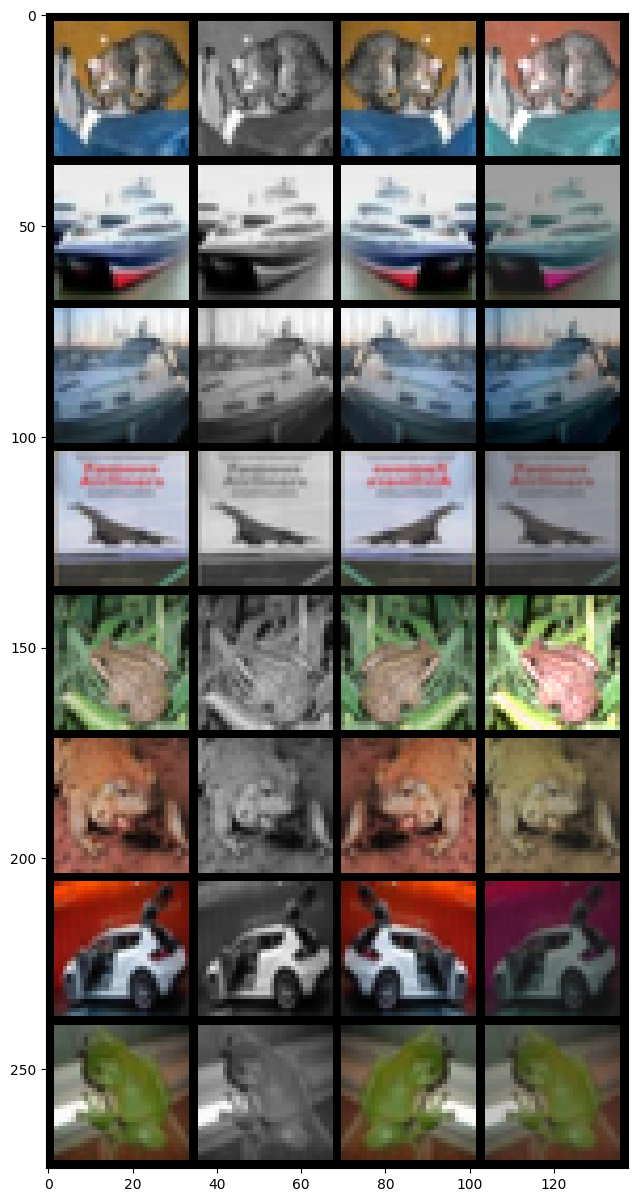

In [10]:
grid_img = torchvision.utils.make_grid(images_transformed.reshape(32, 3, 32, 32), nrow=4)
plt.figure(figsize=(20, 15))
plt.imshow(grid_img.permute(1, 2, 0))

## Dataloaders

In [11]:
batch_size = 128
def get_dataloaders():
    transform_train = transforms.Compose([
                                    transforms.Resize((32,32)),                                
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
                                    transforms.RandomGrayscale(p=0.2),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
                                     ])

    transform = transforms.Compose([transforms.Resize((32,32)),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
                                   ])

    training_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train) # Data augmentation is only done on training images
    validation_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8)
    validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False, pin_memory=True, num_workers=8)
    
    return training_loader, validation_loader

# Models

## Model with Residual Blocks 

One of the key factors of our CNN model is the addition of the residual block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

Residual Block overcame the “vanishing gradient” problem

In [12]:
class ResNet18_CIFAR10(nn.Module):
    def __init__(self, type=''):
        super(ResNet18_CIFAR10, self).__init__()
        self.f = []
        for name, module in resnet18(pretrained=True).named_children():
            if not isinstance(module, nn.Linear):
                self.f.append(module)
        # encoder
        self.feature_extractor = nn.Sequential(*self.f)
        self.linear = nn.Linear(512, 10, bias=True)

    def forward(self, x):
        x = self.feature_extractor(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.linear(feature)
        return out

In [13]:
class ResNet18_K3_CIFAR10(nn.Module):
    def __init__(self, type=''):
        super(ResNet18_K3_CIFAR10, self).__init__()
        self.f = []
        for name, module in resnet18(pretrained=True).named_children():
            if name == 'conv1':
                module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            if not isinstance(module, nn.Linear):
                self.f.append(module)
        # encoder
        self.fe = nn.Sequential(*self.f)
        self.linear = nn.Linear(512, 10, bias=True)

    def forward(self, x):
        x = self.fe(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.linear(feature)
        return out

In [14]:
class ResNet18_K3_NoMaxPool_CIFAR10(nn.Module):
    def __init__(self, type=''):
        super(ResNet18_K3_NoMaxPool_CIFAR10, self).__init__()
        self.f = []
        for name, module in resnet18(pretrained=True).named_children():
            if name == 'conv1':
                module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            if not isinstance(module, nn.Linear) and not isinstance(module, nn.MaxPool2d):
                self.f.append(module)
        # encoder
        self.fe = nn.Sequential(*self.f)
        self.linear = nn.Linear(512, 10, bias=True)

    def forward(self, x):
        x = self.fe(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.linear(feature)
        return out

# Training and validation scripts

In [15]:
def train(model, data_loader, train_optimizer, epoch, epochs):
    model.train()
    total_loss, total_num, train_bar = 0.0, 0, tqdm(data_loader)      
    for data in train_bar:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Move to the GPU
        inputs, labels = inputs.cuda(non_blocking=True), labels.cuda(non_blocking=True)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        total_num += batch_size
        total_loss += loss.item() * batch_size
        train_bar.set_description('Train Epoch: [{}/{}] Loss: {:.4f}'.format(epoch, epochs, total_loss / total_num))
    return total_loss / total_num

In [16]:
def valid(model, data_loader, epoch, epochs):
    model.eval()
    accuracy, total_num, valid_bar = 0, 0, tqdm(data_loader)
    labels_array, prediction_array = [], []
    with torch.no_grad():
        for data in valid_bar:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # Move to the GPU
            inputs, labels = inputs.cuda(non_blocking=True), labels.cuda(non_blocking=True)
            
            outputs = model(inputs)
            predicted = torch.argmax(outputs.data, 1)
            accuracy = accuracy_score(labels.cpu(), predicted.cpu())

            valid_bar.set_description('Valid Epoch: [{}/{}] Accuracy: {:.4f}'.format(epoch, epochs, accuracy))
    return accuracy

In [17]:
def start_train(model, optimizer):
    training_loader, validation_loader = get_dataloaders()
    epochs = 10
    loss_list = []
    accuracy_list = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        loss_list.append(train(model, training_loader, optimizer, epoch, epochs))
        accuracy_list.append(valid(model, validation_loader, epoch, epochs))
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    
    axes[0].plot(loss_list, label='Loss value')
    axes[0].set_title('Loss value')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss value')
    axes[1].plot(accuracy_list, label='Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    
    fig.legend()
    fig.show()

# Train the models

In [18]:
model = ResNet18_CIFAR10().cuda()
flops, params = profile(model, inputs=(torch.randn(1, 3, 32, 32).cuda(),))
flops, params = clever_format([flops, params])
print('# Model Params: {} FLOPs: {}'.format(params, flops))

/opt/conda/lib/python3.8/site-packages/torchvision-0.14.0a0+bd70a78-py3.8-linux-x86_64.egg/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision-0.14.0a0+bd70a78-py3.8-linux-x86_64.egg/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 38.4MB/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
# Model Params: 11.18M FLOPs: 37.22M


Files already downloaded and verified
Files already downloaded and verified


Valid Epoch: [9/10] Accuracy: 0.8233: 100%|███████| 1/1 [00:01<00:00,  1.86s/it]


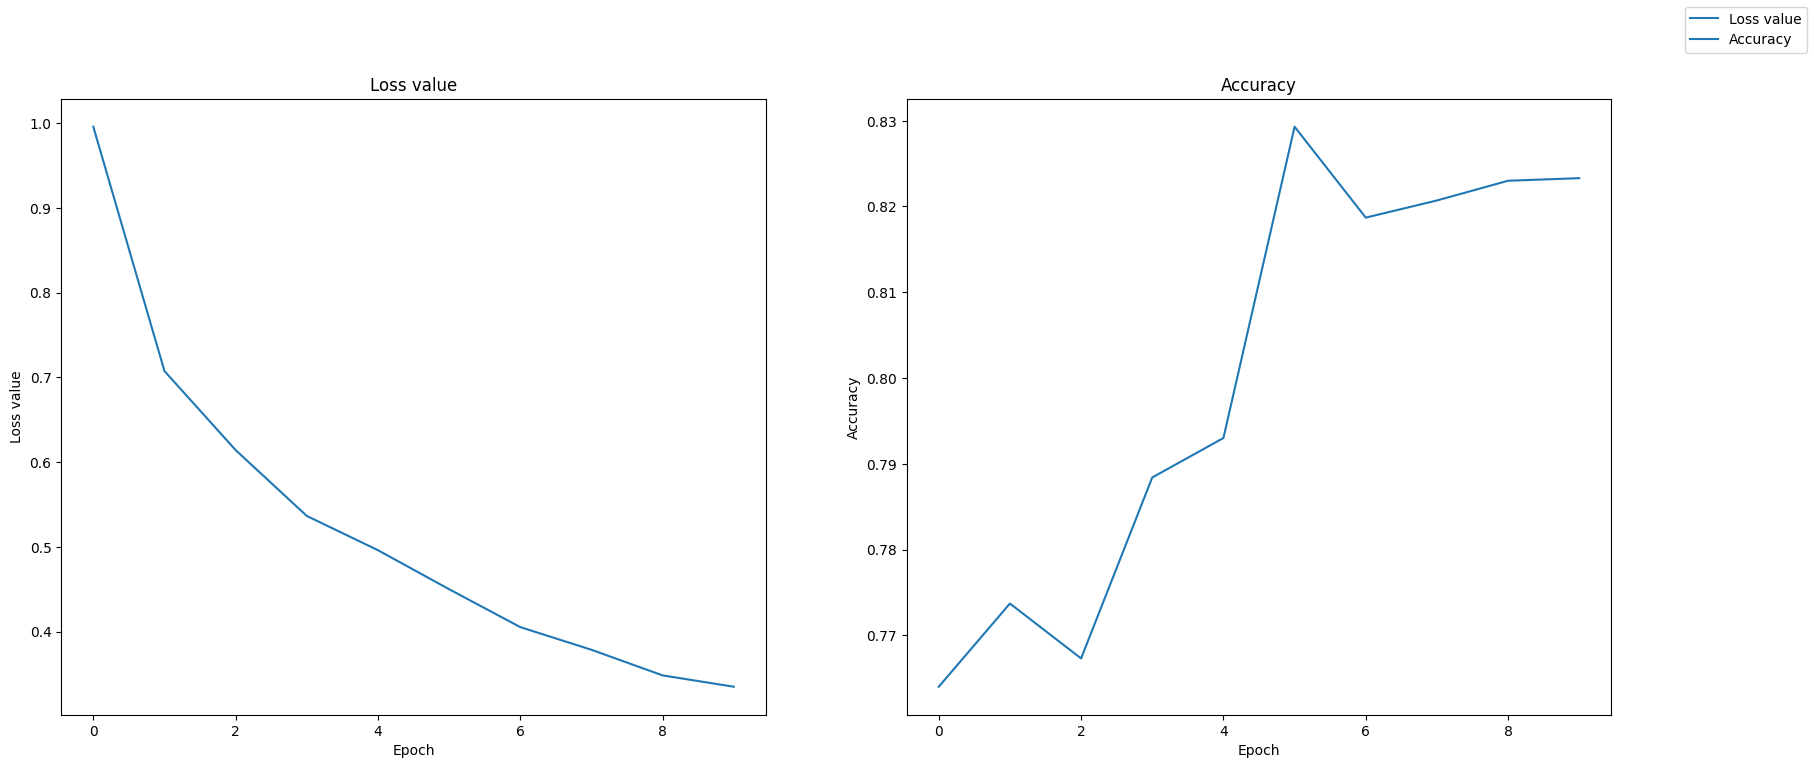

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
start_train(model, optimizer)

In [20]:
model = ResNet18_K3_CIFAR10().cuda()
flops, params = profile(model, inputs=(torch.randn(1, 3, 32, 32).cuda(),))
flops, params = clever_format([flops, params])
print('# Model Params: {} FLOPs: {}'.format(params, flops))

/opt/conda/lib/python3.8/site-packages/torchvision-0.14.0a0+bd70a78-py3.8-linux-x86_64.egg/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision-0.14.0a0+bd70a78-py3.8-linux-x86_64.egg/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
# Model Params: 11.17M FLOPs: 141.00M


Files already downloaded and verified
Files already downloaded and verified


Valid Epoch: [9/10] Accuracy: 0.8629: 100%|███████| 1/1 [00:02<00:00,  2.05s/it]


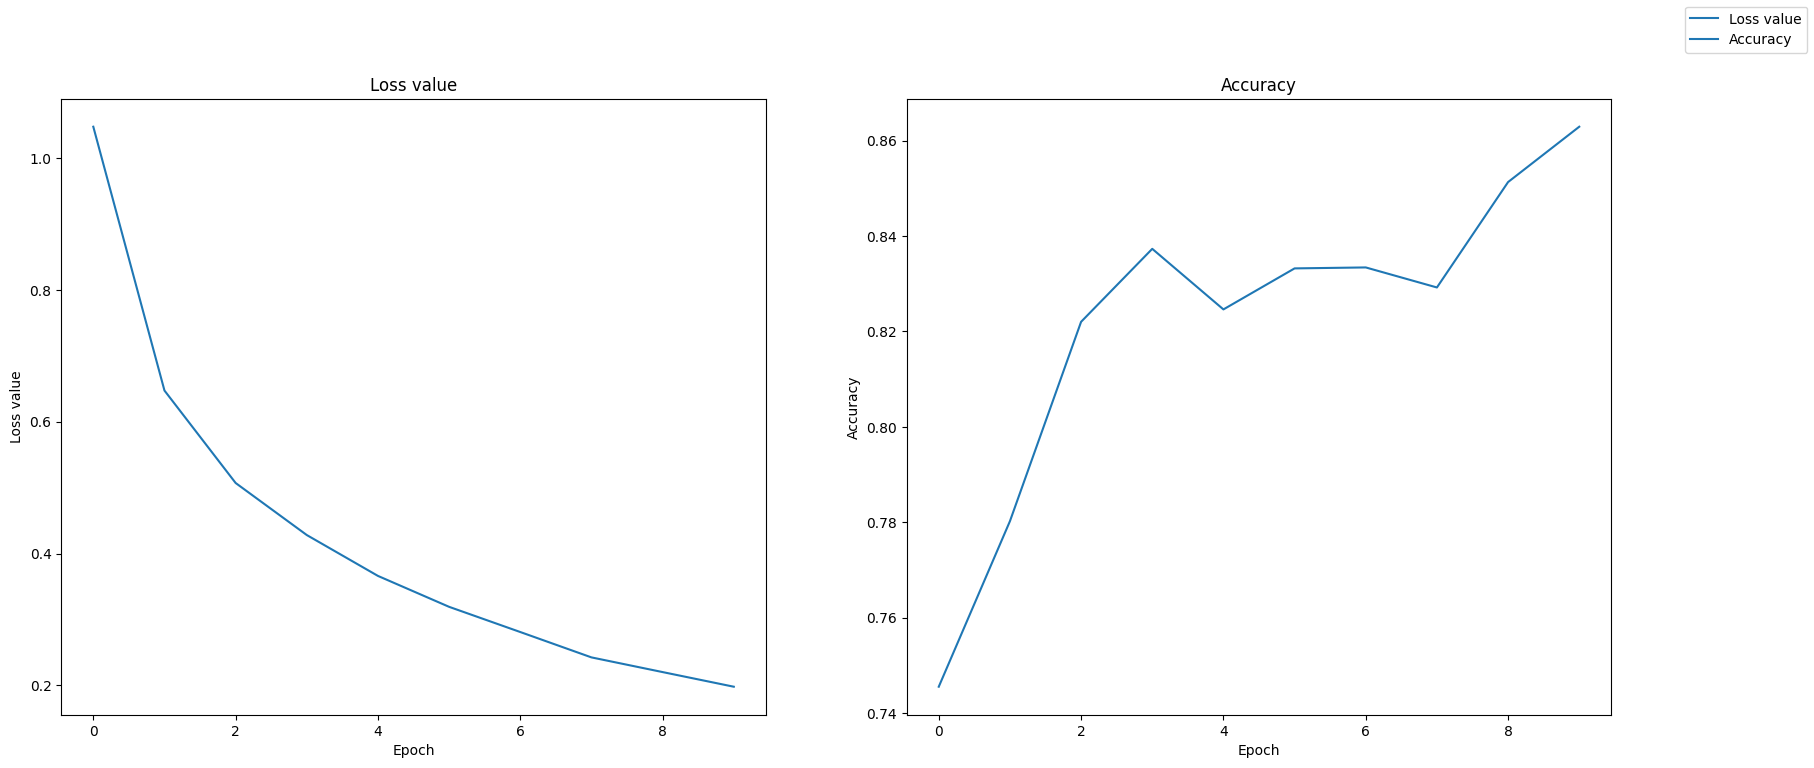

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
start_train(model, optimizer)

In [22]:
model = ResNet18_K3_NoMaxPool_CIFAR10().cuda()
flops, params = profile(model, inputs=(torch.randn(1, 3, 32, 32).cuda(),))
flops, params = clever_format([flops, params])
print('# Model Params: {} FLOPs: {}'.format(params, flops))

/opt/conda/lib/python3.8/site-packages/torchvision-0.14.0a0+bd70a78-py3.8-linux-x86_64.egg/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision-0.14.0a0+bd70a78-py3.8-linux-x86_64.egg/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
# Model Params: 11.17M FLOPs: 557.89M


Files already downloaded and verified
Files already downloaded and verified


Valid Epoch: [9/10] Accuracy: 0.8848: 100%|███████| 1/1 [00:02<00:00,  2.71s/it]


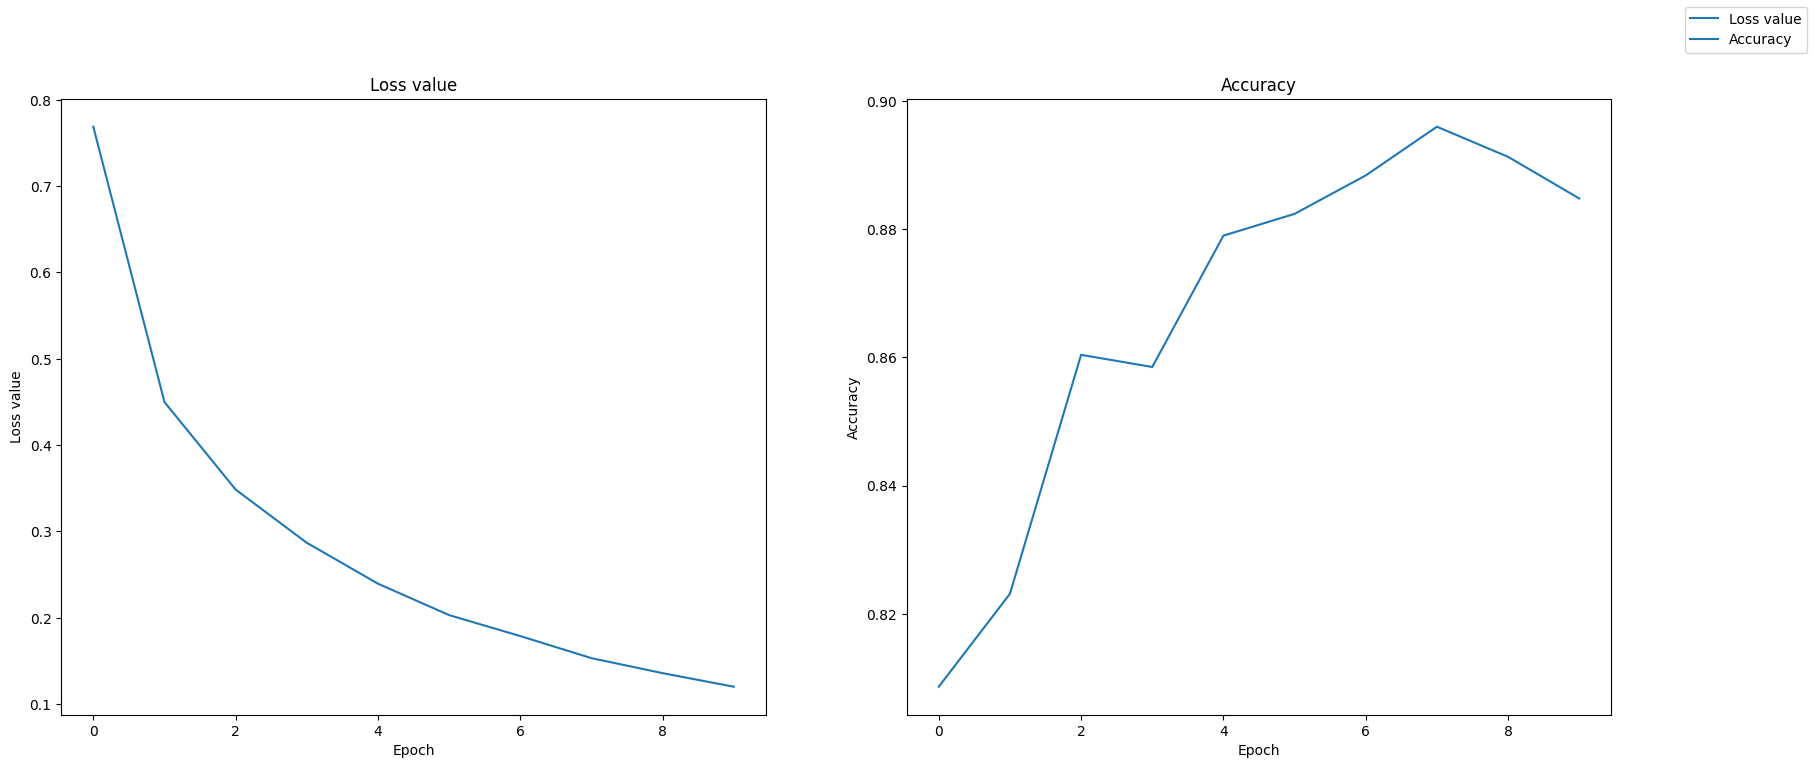

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
start_train(model, optimizer)

# Summary
In this lab, we have learned how to train a deep neural network with PyTorch framework on the AMD GPUs.